# 1.) Import the data from CCLE into a new Google Colab file

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive

In [6]:
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


In [7]:
df = pd.read_csv("/content/gdrive/MyDrive/Econ441B/insurance.csv")

In [8]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [26]:
df["region"].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [35]:
df.loc[df["sex"] == "female","sex" ] = 1
df.loc[df["sex"] == "male","sex"] = 0

df.loc[df["smoker"] == "yes","smoker" ] = 1
df.loc[df["smoker"] == "no","smoker"] = 0

df.loc[df["region"] == "southwest","region" ] = 0
df.loc[df["region"] == "southeast","region"] = 1
df.loc[df["region"] == "northwest","region" ] = 2
df.loc[df["region"] == "northeast","region"] = 3

In [88]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,0,16884.92400
1,18,0,33.770,1,0,1,1725.55230
2,28,0,33.000,3,0,1,4449.46200
3,33,0,22.705,0,0,2,21984.47061
4,32,0,28.880,0,0,2,3866.85520


# 2.) Split the data into 80/20, in/out sample

In [36]:
import numpy as np

In [37]:
data = np.array(df.iloc[:,:-1]) 
target = np.array(df.iloc[:,-1])

In [38]:
cut = int((len(data)*.8)//1)

In [39]:
in_data = data[:cut]
out_data = data[cut:]

in_target = target[:cut]
out_target = target[cut:]

# 3.) Normalize the Data

In [40]:
from sklearn import preprocessing

In [53]:
scaler = preprocessing.StandardScaler().fit(in_data)
in_data_scaler = scaler.transform(in_data)

out_data_scaler = scaler.transform(out_data)

In [54]:
in_data_scaler

array([[-1.45390122,  1.02077653, -0.47403991, -0.90286618,  1.99417757,
        -1.34066165],
       [-1.52464584, -0.97964634,  0.4911621 , -0.06353793, -0.50145986,
        -0.4373191 ],
       [-0.81719959, -0.97964634,  0.36455128,  1.61511857, -0.50145986,
        -0.4373191 ],
       ...,
       [-0.03900872, -0.97964634,  1.95211949, -0.90286618, -0.50145986,
         1.36936599],
       [ 1.65886228, -0.97964634, -1.50008089, -0.06353793, -0.50145986,
         0.46602344],
       [ 1.02216066,  1.02077653,  0.18367867, -0.06353793, -0.50145986,
        -0.4373191 ]])

In [55]:
out_data_scaler

array([[-0.18049797, -0.97964634,  1.03377993, -0.06353793,  1.99417757,
        -0.4373191 ],
       [ 1.65886228, -0.97964634,  0.10886318, -0.90286618, -0.50145986,
         1.36936599],
       [-1.31241197, -0.97964634,  0.07762155, -0.90286618, -0.50145986,
         0.46602344],
       ...,
       [-1.52464584,  1.02077653,  0.99760541, -0.90286618, -0.50145986,
        -0.4373191 ],
       [-1.31241197,  1.02077653, -0.81934216, -0.90286618, -0.50145986,
        -1.34066165],
       [ 1.51737303,  1.02077653, -0.28165722, -0.90286618,  1.99417757,
         0.46602344]])

# 4.) Get lambda from Lasso cross validation

In [56]:
from sklearn.linear_model import LassoCV
modCV = LassoCV().fit(in_data_scaler,in_target)
a = modCV.alpha_

In [57]:
a

133.34880015958146

# 5.) Run a lasso regression with that Lambda

In [79]:
from sklearn.linear_model import Lasso
mod1 = Lasso(alpha=a).fit(in_data_scaler,in_target)
mod1.predict(np.array(in_data_scaler))

array([24933.78011265,  3864.47297708,  6815.10290666, ...,
       12177.79520243, 11741.14195836, 12360.55112834])

In [80]:
coef_values = mod1.coef_
coef_values

array([3564.26137833,    0.        , 1890.8527485 ,  398.24050447,
       9324.84227138,  326.52198757])

# 6.) Visualize the coefficients 

In [81]:
Variables = (df.columns)[:-1]
Variables

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

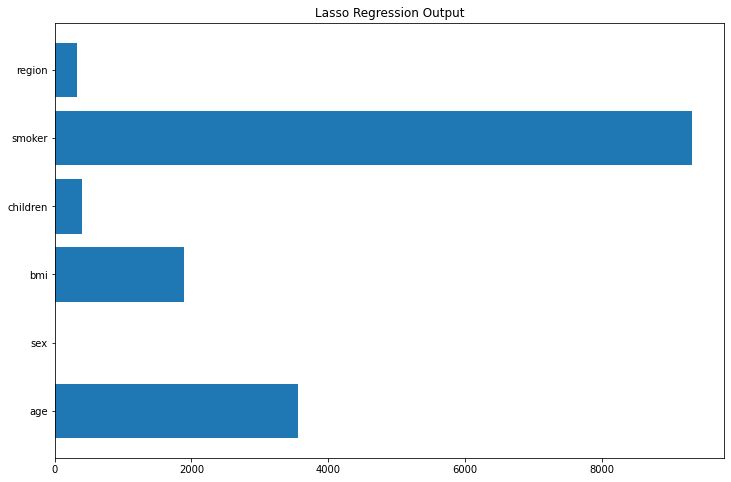

In [82]:
plt.figure(figsize=(12,8))
plt.barh(Variables,coef_values)
plt.title('Lasso Regression Output')
plt.show()

# 7.) Interpret the coefficients

If we need to interpret those coefficients in a more rigorous way, we need to unnormalize those coefficients first. However, we can make a simpler interpretation here.

1. As for the age, when you increase 1 year old, the charge will be 3564.26 more.
2. As for sex, we can find that there is no difference for charge between male and female.
3. As for bmi, when you increase 1 more unit in bmi, the charge will be 1890.85 hiher.
4. As for # of children, if you have 1 more child, the charge will be 398.24 higher.
5. As for smoker, we can find that the chagre for smoker is 9324.84 higher than non-somker.
6. As for region, we can find that the charges difference between southwest and other regions is 326.52.

# 8.) Compare in and out of sample MSE’s

In [83]:
from sklearn import metrics

In [85]:
predict1 = mod1.predict(np.array(in_data_scaler))
MSE1 = metrics.mean_squared_error(in_target, predict1)

predict2 = mod1.predict(np.array(out_data_scaler))
MSE2 = metrics.mean_squared_error(out_target, predict2)

In [86]:
MSE1

36490415.101693384

In [87]:
MSE2

37252730.724018715

We can find that the MSE of the in sample is lower than the MSE of the out sample.